In [1]:
import openai
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from googlesearch import search
from docx import Document
import re
import requests
import nltk
import spacy

In [2]:
os.getcwd()

'e:\\GoogleDrive\\Beruf\\Freelancing\\Code_Repo\\NLP_Text_Generation_Webapp\\experiment'

In [3]:
%cd ..

e:\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp


In [4]:
%cd web_app

e:\GoogleDrive\Beruf\Freelancing\Code_Repo\NLP_Text_Generation_Webapp\web_app


In [5]:
with open('private.txt', 'r') as f:
    content = f.read()
    key = re.findall(r'\'.*?\'', content)[0].strip('\'')
    openai.api_key = key
f.close()

#%cd ..experiment    

# Utility

In [6]:
def parse_date_from_html(html_string):
    "parse date from html. Input html as byte object. The output is a string."
    try:
        regex = b"\d{4}-\d{2}-\d{2}" # b stands for byte like! not a string yet
        date = re.search(regex, html_string)[0]
        date_string = date.decode('utf-8') # turn to string
    except:
        try:
            regex = b"\d{4}\/\d{2}\/\d{2}" # b stands for byte like! not a string yet
            date = re.search(regex, html_string)[0]
            date_string = date.decode('utf-8')#.replace("/", "-") # turn to string
        except:
            date_string = 'no date detected'
    return date_string

def parse_title_from_html(html_string):
    "parse_title_from_html. Input html as byte object. The output is a string."
    try:
        title = re.search(b'<title>(.*?)</title>', html_string).group(1)
        title = title.decode('utf-8')
        title = title.split('.')[0].split('&')[0].split('|')[0].split('-')[0]
    except:
        title = 'no title detected'
    return title

def google_query(keywords, num_results=10):
  "query google by topics and return the url, the title and the publication date for each search result as lists"
  source_google = []
  titles_google = []
  publication_dates_google = []

  for kw in keywords:
    query = kw
    for url in search(query, num_results, lang="de"):
        # get html string
        html_string = requests.get(url).content     
        # get title
        title = parse_title_from_html(html_string)
        # get date
        date = parse_date_from_html(html_string)
        # save results in lists
        source_google.append(url)
        titles_google.append(title)
        publication_dates_google.append(date)

        print(url)  
        print(title)
        print(date)

  return source_google, titles_google, publication_dates_google

def chatgpt_generate_topics(keywords, num_topics):
    "Give ChatGPT instructions to generate num_topics for the given keywors"
    instruction = \
    '\n' \
    "Nenne zu folgenden Keywords " + '\n' \
    'keywords = ' + str(keywords)  + '\n' \
    ' ' + str(num_topics) + '\n' \
    ' Themenüberschriften.'
    print('Instruction: ', instruction)
    return instruction

# Define Keywords

In [7]:
# define key words
keywords = ['Finanzielle Hilfe im Alter', 
            'Rentner in Not',
            'Armut Senioren',
            'Altersarmut Frauen',
            'Renten Pay-Gap',
            'Unterstützung Rentner']

# Generate Topic List 

## Generate Topics from Latest Article Headlines Found by Google Search

In [8]:
# get google search results for each topic
source_google, titles_google, publication_dates_google = google_query(keywords, num_results=10)

https://familienportal.de/familienportal/lebenslagen/alter/staatliche-leistungen
Staatliche Leistungen im Alter 
no date detected
https://www.caritas.de/hilfeundberatung/ratgeber/alter/pflege/finanzielle-hilfe-wenn-die-rente-nicht-reicht
Finanzielle Hilfe wenn die Rente nicht reicht
2021-10-04
https://www.seniorenlebenshilfe.de/dienstleistungen-fuer-senioren/grundsicherung-im-alter/
Wichtige Infos zur Grundsicherung im Alter 
2021-07-13
https://www.focus.de/finanzen/altersvorsorge/staatliche-unterstuetzung-viel-mehr-geld-im-alter-sieben-lohnende-zuschuesse-fuer-rentner_id_8970984.html
Viel mehr Geld im Alter: Sechs lohnende Zuschüsse für Rentner 
2018-05-25
https://www.kennstdueinen.de/magazin/geldnot-im-alter-welche-finanziellen-hilfen-gibt-es-wenn-die-rente-nicht-reicht/
Geldnot im Alter 
2015-09-04
https://www.serviceportal-zuhause-im-alter.de/wohnen/laenger-zuhause-wohnen/finanzielle-foerderung.html
Finanzielle Förderung 
no date detected
https://www.ihre-vorsorge.de/magazin/lesen/

In [9]:
#source_google = []
#titles_google = []
#publication_dates_google = []
len(publication_dates_google)

63

In [10]:
# turn titles and sources into dataframe
df_titles_google = pd.DataFrame({'source': source_google, 'title': titles_google, 'date': publication_dates_google})
df_titles_google.head(10)

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
3,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
4,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
5,https://www.serviceportal-zuhause-im-alter.de/...,Finanzielle Förderung,no date detected
6,https://www.ihre-vorsorge.de/magazin/lesen/wen...,Wenn das Geld im Alter nicht reicht: Finanziel...,2023-05-22
7,https://www.einherzfuerrentner.de/fuer-rentner/,Für Rentner,2023-02-27
8,https://www.betanet.de/sozialhilfe-altenhilfe....,Sozialhilfe > Altenhilfe,no date detected
9,https://www.wege-zur-pflege.de/themen/finanzie...,Finanzielle Unterstützung: Wege zur Pflege,2022-12-23


## Generate Topics Based on ChatGPT

In [11]:
keywords

['Finanzielle Hilfe im Alter',
 'Rentner in Not',
 'Armut Senioren',
 'Altersarmut Frauen',
 'Renten Pay-Gap',
 'Unterstützung Rentner']

In [12]:
instruction = chatgpt_generate_topics(keywords=keywords, num_topics=15)

Instruction:  
Nenne zu folgenden Keywords 
keywords = ['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
 15
 Themenüberschriften.


In [13]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

titles_chatgpt = response['choices'][0].text

# format titles and put into list
titles_chatgpt = [title.strip().replace("\n", "").replace(". ", "") for title in re.split(r'\d+', titles_chatgpt)]

In [14]:
# turn titles and sources into dataframe
date_today = datetime.date.today().strftime("%Y-%m-%d")
df_titles_chatgpt = pd.DataFrame({'source': 'chatgpt', 'title': titles_chatgpt, 'date': date_today})
df_titles_chatgpt.head(10)

,source,title,date
0,chatgpt,,2023-05-23
1,chatgpt,Finanzielle Unterstützung für ältere Menschen,2023-05-23
2,chatgpt,Rentner in Not: Wie wir helfen können,2023-05-23
3,chatgpt,Armut bei Senioren: Ein großes Problem,2023-05-23
4,chatgpt,Altersarmut bei Frauen: Eine zunehmende Heraus...,2023-05-23
5,chatgpt,Der Renten-Pay-Gap: Was müssen wir tun?,2023-05-23
6,chatgpt,Unterstützung für Rentner – Welche Möglichkeit...,2023-05-23
7,chatgpt,Finanzielle Sicherheit im Alter – Was können w...,2023-05-23
8,chatgpt,Wie können wir Rentnern in Not helfen?,2023-05-23
9,chatgpt,Altersarmut bei Frauen – Ein aktuelles Problem,2023-05-23


In [23]:
# concat both title dataframes
df_titles = pd.concat([df_titles_google, df_titles_chatgpt], axis=0, ignore_index=True)
df_titles

,source,title,date
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04
2,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13
3,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25
4,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04
...,...,...,...
74,chatgpt,Unterstützung für ältere Menschen – Welche Opt...,2023-05-23
75,chatgpt,Finanzielle Hilfe für Senioren – Was sollten w...,2023-05-23
76,chatgpt,"Armut unter Senioren: Eine Herausforderung, de...",2023-05-23
77,chatgpt,Altersarmut bei Frauen: Wie können wir helfen?,2023-05-23


## Apply Topic-Keyword Similarity Filter

In [24]:
# load the preinstalled version
nlp = spacy.load("de_core_news_lg")

type(nlp)

OSError: [E050] Can't find model 'de_core_news_lg'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# measure similarity between the titles and the keywords
title_keyword_similarity = []
for title in df_titles['title']:
  sim_score = 0
  for kw in keywords:
    sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability
  # append sum of similarity scores
  title_keyword_similarity.append(np.round(sim_score, 2))

C:\Users\Sebas\AppData\Local\Temp\ipykernel_30220\4193192492.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_score += nlp(title).similarity(nlp(kw)) / len(keywords) # average similarity score for better interpretability


In [ ]:
# Add title-keyword similarity scores to df_titles
df_titles['keyword_similarity'] = title_keyword_similarity
df_titles.head()

,source,title,date,keyword_similarity
0,https://familienportal.de/familienportal/leben...,Staatliche Leistungen im Alter,no date detected,0.40
1,https://www.caritas.de/hilfeundberatung/ratgeb...,Finanzielle Hilfe wenn die Rente nicht reicht,2021-10-04,0.40
2,https://www.kennstdueinen.de/magazin/geldnot-i...,Geldnot im Alter,2015-09-04,0.33
3,https://www.seniorenlebenshilfe.de/dienstleist...,Wichtige Infos zur Grundsicherung im Alter,2021-07-13,0.30
4,https://www.focus.de/finanzen/altersvorsorge/s...,Viel mehr Geld im Alter: Sechs lohnende Zuschü...,2018-05-25,0.39


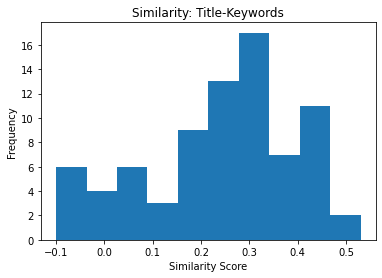

In [ ]:
# show title-similarity distribution
plt.hist(df_titles['keyword_similarity'])
plt.title('Similarity: Title-Keywords')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# filter out similarity score < 0.1
df_titles = df_titles[df_titles['keyword_similarity'] > 0.1]
df_titles = df_titles.sort_values(by='keyword_similarity', ascending=False, ignore_index=True)
df_titles

,source,title,date,keyword_similarity
0,https://www.mutter-teresa-stiftung.de/startsei...,Altersarmut,2022-11-03,0.53
1,https://www.bpb.de/kurz-knapp/zahlen-und-fakte...,Altersarmut,2020-11-28,0.53
2,https://frauen.verdi.de/themen/rente/++co++c0b...,Frauen haben niedrigere Renten – ver,no date detected,0.46
3,https://www.destatis.de/DE/Themen/Querschnitt/...,Armutsgefährdung sowie materielle und soziale ...,2022-08-23,0.44
4,https://www.deutsche-rentenversicherung.de/DRV...,Grundsicherung,2022-04-30,0.43
...,...,...,...,...
56,chatgpt,Die finanziellen Herausforderungen des Älterwe...,2023-03-07,0.19
57,https://www.dza.de/detailansicht/im-arbeitsleb...,Im Arbeitsleben und im Ruhestand: gravierende ...,2022-10-18,0.18
58,https://www.malteser.de/dabei/information-tipp...,Altersarmut in Deutschland: Ein Überblick,no date detected,0.17
59,https://www.aktion-deutschland-hilft.de/de/fac...,Wie entsteht Altersarmut?,no date detected,0.14


## Save Topic Ideation as Word Document

In [ ]:
# create a word document 
document = Document()

# add table to document
table = document.add_table(rows=1, cols=4)
table.style = 'Table Grid'

# add table header
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Source'
hdr_cells[1].text = 'Title'
hdr_cells[2].text = 'Date'
hdr_cells[3].text = 'Keyword Similarity'

# add data to table
for i in range(len(df_titles)):
    row_cells = table.add_row().cells
    row_cells[0].text = df_titles.iloc[i]['source']
    row_cells[1].text = df_titles.iloc[i]['title']
    row_cells[2].text = df_titles.iloc[i]['date']
    row_cells[3].text = str(df_titles.iloc[i]['keyword_similarity'])

# save word document
document.save('topic_ideation.docx')

# Advise ChatGPT to Write Article for Given Topic

In [ ]:
topic = df_titles['title'][2]
print(topic)

Frauen haben niedrigere Renten – ver


In [ ]:
instruction = "\n" + \
"Schreibe einen Artikel von 250 Wörtern zum Thema: \n" + \
topic + '. \n' + \
"Der Artikel soll die Schlüsselbegriffe " + '\n' + \
str(keywords) + '\n' + \
"enthalten." + '\n' + \
"Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein." + '\n' + \
"Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten."

print('Instruction: ', instruction)

Instruction:  
Schreibe einen Artikel von 250 Wörtern zum Thema: 
Frauen haben niedrigere Renten – ver. 
Der Artikel soll die Schlüsselbegriffe 
['Finanzielle Hilfe im Alter', 'Rentner in Not', 'Armut Senioren', 'Altersarmut Frauen', 'Renten Pay-Gap', 'Unterstützung Rentner']
enthalten.
Desweiteren soll der Artikel in Absätze und Überschriften unterteilt sein.
Desweiteren sollen die Überschriften die Schlüsselbegriffe enthalten.


In [ ]:
response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=instruction,
    temperature=.5,
    max_tokens=1000,
    top_p=1,
    n=2,
    presence_penalty=.5,
    frequency_penalty=.5,
)

text_seo = response['choices'][0].text

In [ ]:
print(text_seo)



Finanzielle Hilfe im Alter: Frauen haben niedrigere Renten 
Es ist ein trauriger Fakt, dass viele Rentner in Not leben und sich mit Altersarmut auseinandersetzen müssen. Eine Gruppe, die besonders betroffen ist, sind Frauen. Sie erhalten im Schnitt wesentlich niedrigere Renten als Männer und sind daher besonders gefährdet, in Armut zu geraten. 

Renten Pay-Gap: Unterschiede zwischen Männern und Frauen 
Einer der Gründe für den Renten Pay-Gap zwischen Männern und Frauen liegt in den unterschiedlichen Erwerbsbiografien. Da Frauen häufig weniger verdienen als Männer und oftmals auch länger pausieren, um Kinder oder pflegebedürftige Angehörige zu betreuen, haben sie letztendlich wesentlich geringere Renteansprüche als ihre männlichen Kolleginnen. 

Armut Senioren: Unterstützung für Rentner notwendig 
Um dem Problem der Altersarmut bei Frauen entgegenzuwirken, ist es wichtig, dass Senioren ausreichend finanziell unterstützt werden. Der Staat hat hier eine besondere Verantwortung und sollt

## Save SEO Text as Word Document

In [ ]:
# Create a new document object.
document = Document()

# Create a new paragraph object.
paragraph = document.add_paragraph()

# Write the string to the paragraph object.
paragraph.add_run(text_seo)

# Save the document.
document.save('seo_text.docx')

# ToDo

- Include Keywords into article generation -> ok
- Add column with publication date! -> ok
- Save Topic List and hand over to Alexa -> warte auf Feedback
- correct topic titles
- code review: make functions
- develop streamlit app
    - update button for topic list after setting configs
    - download button for topic list